In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/fruits"))
print(os.listdir("../input/fruits/fruits-360_dataset"))
print(os.listdir("../input/fruits/fruits-360_dataset/fruits-360"))


# Any results you write to the current directory are saved as output.

['fruits']
['fruits-360_dataset']
['readme.md', 'fruits-360']
['Training', 'readme.md', 'test-multiple_fruits', 'Test', 'LICENSE', 'papers']


In [2]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import os
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

In [3]:
img_dir = '../input/fruits/fruits-360_dataset/fruits-360/Training'
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(img_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [8]:
len(dataset.classes)


118

In [9]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [10]:
dataset = datasets.ImageFolder(img_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

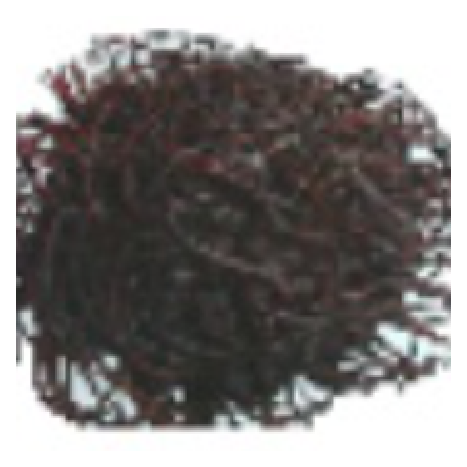

In [11]:
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

In [12]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(size=224),  # Image net standards
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


In [13]:
#Loading in the dataset

train_data = datasets.ImageFolder(img_dir,transform=train_transforms)
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=test_sampler, num_workers=num_workers)

11865 5933 41530


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pretrained=True will download a pretrained network for us
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /tmp/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 122MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
#Freezing model parameters and defining the fully connected network to be attached to the model, loss function and the optimizer.
#We there after put the model on the GPUs
for param in model.parameters():
  param.require_grad = False
fc = nn.Sequential(
    nn.Linear(1024, 460),
    nn.ReLU(),
    nn.Dropout(0.4),
    
    nn.Linear(460,118),
    nn.LogSoftmax(dim=1)
    
)
model.classifier = fc
criterion = nn.NLLLoss()
#Over here we want to only update the parameters of the classifier so
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.003)
model.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
def train(n_epochs, model, optimizer, criterion, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [20]:
train(10, model, optimizer, criterion, 'demo.pt')

Epoch 1, Batch 1 loss: 4.896480
Epoch 1, Batch 101 loss: 3.778049
Epoch 1, Batch 201 loss: 2.894694
Epoch 1, Batch 301 loss: 2.393348
Epoch 1, Batch 401 loss: 2.079768
Epoch 1, Batch 501 loss: 1.852778
Epoch 1, Batch 601 loss: 1.688215
Epoch 1, Batch 701 loss: 1.565479
Epoch 1, Batch 801 loss: 1.462776
Epoch 1, Batch 901 loss: 1.379314
Epoch 1, Batch 1001 loss: 1.309941
Epoch 1, Batch 1101 loss: 1.251169
Epoch 1, Batch 1201 loss: 1.198022
Epoch: 1 	Training Loss: 1.154066 	Validation Loss: 0.132591
Validation loss decreased (inf --> 0.132591).  Saving model ...
Epoch 2, Batch 1 loss: 0.709506
Epoch 2, Batch 101 loss: 0.632447
Epoch 2, Batch 201 loss: 0.630656
Epoch 2, Batch 301 loss: 0.601755
Epoch 2, Batch 401 loss: 0.615559
Epoch 2, Batch 501 loss: 0.612501
Epoch 2, Batch 601 loss: 0.599338
Epoch 2, Batch 701 loss: 0.589950
Epoch 2, Batch 801 loss: 0.584100
Epoch 2, Batch 901 loss: 0.577793
Epoch 2, Batch 1001 loss: 0.572395
Epoch 2, Batch 1101 loss: 0.567965
Epoch 2, Batch 1201 loss

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
ls

__notebook_source__.ipynb  demo.pt


In [22]:
model.load_state_dict(torch.load('demo.pt'))

<All keys matched successfully>

In [23]:
def test(model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(model, criterion)

Test Loss: 0.030609


Test Accuracy: 98% (5867/5933)
